In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from tqdm.notebook import tqdm as tqdm
import json
import torch.nn.functional as F
import torch.nn as nn

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
    IMAGE_DIR = path_dict['large_faces']
#IMAGE_DIR = '/media/joni/DeepFake/large_faces_2/'
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
from util.ImageSampling import getBalancedVideoDataFrame

**Data rules**

- 1st level 4th fold is validation
- Only one person cases
- Remove nans and videos without proper face detections
- Sample order: real1, random_fake_of_real_1, real2, random_fake_of_real_2, ...

In [3]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['person_count']==1]
df = df[df['first_person_label']>-1]
df['isValFold'] = df['cv_fold'] == 2
df = df[df['cv_fold']<5]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version,isValFold
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17,False
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17,False
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17,False
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17,False
5,duhilxsfwa.mp4,FAKE,1st_level,False,2,1,3.0,NaN,"[3, 2, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, ...",NaN,pfbdxvexft.mp4,2020-02-17,True


In [4]:
#df_balanced = getBalancedVideoDataFrame(df)
#df_balanced.head()

In [4]:
#df_balanced.to_csv('../tmp/df_balanced.csv',index=False)
df_balanced = pd.read_csv('../tmp/df_balanced.csv')

In [5]:
len(df_balanced)

26310

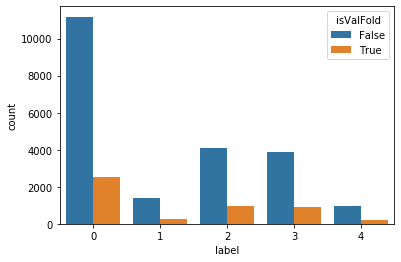

In [6]:
sns.countplot(x='label',hue='isValFold',data=df_balanced)

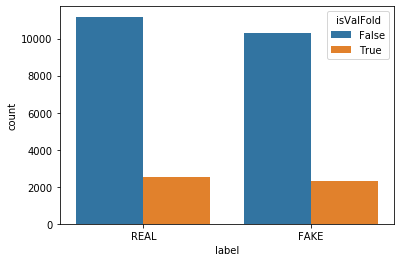

In [7]:
df_balanced['label'] = np.where(df_balanced['label'] > 0, 'FAKE', 'REAL')
sns.countplot(x='label',hue='isValFold',data=df_balanced)

In [8]:
df_balanced['path'] = [s.replace('.mp4','') for s in df_balanced['path'].values]
df_balanced.head()

,path,label,isValFold
0,pfzfafciut,REAL,True
1,vyejvtyqyq,FAKE,True
2,tblxwzpbdy,REAL,False
3,pyvrjronhh,FAKE,False
4,mcmztvtjaz,REAL,True


## Multiframe dataloader

In [9]:
sys.path.append('../detector/')
from RecurrentModel.RecurrentCNN import MixedVideoSequenceModel
from RecurrentModel.RecurrentModelConfig import RecurrentModelConfig
from RecurrentModel.ImageSequence import ImageSequence
from RecurrentModel.ImageSequenceList import ImageSequenceList

In [11]:
%load_ext autoreload
%autoreload 2

In [10]:
recurrent_config = RecurrentModelConfig(len_sequence=5,
                                        min_frame_index=10,
                                        max_frame_index=16)

RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16


In [11]:
from util.fastaiAugmentations import JPEGAugment, HueSaturationValueAugment

In [12]:
tfms = get_transforms(max_zoom=1.4,#1.0, 
                      max_rotate=10,#0, 
                      max_warp=0.0,#0,
                      max_lighting=0.4,
                      xtra_tfms=[JPEGAugment(p=0.7),HueSaturationValueAugment(p=0.2)])

videoSequenceBunch = (ImageSequenceList.from_df(path=IMAGE_DIR,
                                                df=df_balanced)
                    #.split_by_rand_pct(0.2)
                    .split_from_df('isValFold')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='label')
                    #Where are the labels?
                    .transform(tfms)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=2))

# don't shuffle to keep the ordered real-fake pairs in the same batches
videoSequenceBunch.train_dl = videoSequenceBunch.train_dl.new(shuffle=False)

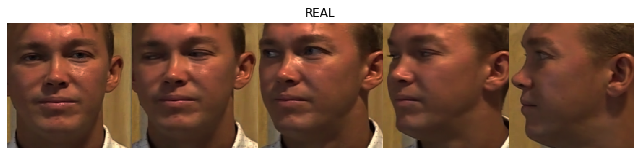

In [13]:
videoSequenceBunch.show_batch()

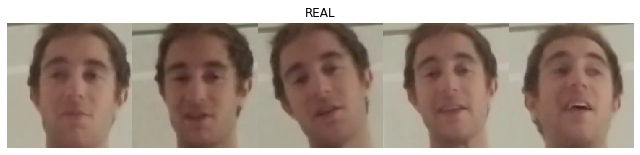

In [14]:
videoSequenceBunch.show_batch(ds_type=DatasetType.Valid)

In [15]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision import learner

# load the starting point, a trained large face model
pretrained_encoder = load_learner('../models/large_face_classifier/2020_03_12-f2/')

# Train

In [16]:
model = MixedVideoSequenceModel(pretrained_encoder.model, ps=0.8).cuda()

### Pretrained CNN backbone

Apply initialization

In [17]:
apply_init(model.conv1d, nn.init.kaiming_normal_)
apply_init(model.recurrent, nn.init.kaiming_normal_)
apply_init(model.linear1, nn.init.kaiming_normal_)
apply_init(model.linear2, nn.init.kaiming_normal_)

In [18]:
from fastai.layers import LabelSmoothingCrossEntropy
learn = Learner(videoSequenceBunch,
                model,
                metrics=[accuracy, error_rate],
                loss_func=LabelSmoothingCrossEntropy())#.mixup()

In [19]:
# Freeze the pretrained part at first
#learn.freeze_to(1) # freezes 0 but keeps layer_groups >= 1 unfreezed
learn.unfreeze()

In [20]:
# freeze body
for param in learn.model.body.parameters():
    param.requires_grad = False

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


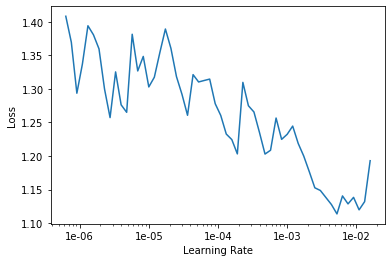

In [21]:
#learn.lr_find()
learn.lr_find()#(num_it=200)
learn.recorder.plot()

In [24]:
#from fastai.callbacks.misc import StopAfterNBatches

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.304907,0.435780,0.915635,0.084365,18:32


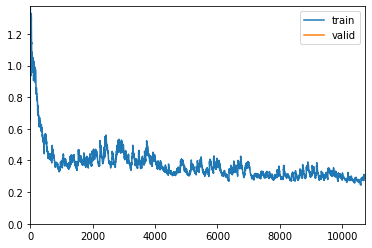

In [22]:
#stop_after = StopAfterNBatches(n_batches=4000)
showGraph = ShowGraph(learn)

learn.fit_one_cycle(1, 1e-4, callbacks=[showGraph])

# Export the model

In [23]:
# load best
#learn.load('best')

In [24]:
if not os.path.exists('../models/lstm'):
    os.mkdir('../models/lstm')
os.mkdir('../models/lstm/2020_03_17-f2-GRU-conv')

In [25]:
learn.export(file="/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/lstm/2020_03_17-f2-GRU-conv/export.pkl")

In [26]:
recurrent_config.toDir("/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/lstm/2020_03_17-f2-GRU-conv/")